#### Libraries Installation
!pip install outlier_utils
!pip install imbalanced-learn 
!pip install delayed
!pip install missingno
!pip install plotly
!pip install lightgbm
!pip install xgboost
!pip install category_encoders
!pip install shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# allows us to implement a train test split strategy
from sklearn.model_selection import train_test_split

# access to the logistic regression class of Sklearn
from sklearn.linear_model import LogisticRegression

# access to the neural network model MLP Classifier
from sklearn.neural_network import MLPClassifier

# classification metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## TRAIN TEST SPLIT

In [2]:
# Read Training Set
df = pd.read_csv('train.csv',dtype={
                             'ip': np.uint8,
                             'app': np.uint8,
                             'device' : np.uint8,
                             'os' : np.uint8,
                             'channel' : np.uint8,
                             'is_attributed' : np.uint8    
                        },parse_dates=['click_time'])

In [3]:
df['day'] = df['click_time'].dt.day.astype('uint8')
# Get oot
#oot = df[df['day']==8]

# Get Train
df = df[df['day']==7]

In [4]:
df['hour'] = df['click_time'].dt.hour.astype('uint8')
df['minute'] = df['click_time'].dt.minute.astype('uint8')
df['second'] = df['click_time'].dt.second.astype('uint8')

#Edit minute variable to two-digit string
df['minute'] = df['minute'].apply(lambda x: '{0:0>2}'.format(x))

In [5]:
click_outlier = 14507.5
ratio_outlier = 812.8342105263157

In [6]:
# Transform

ranges = [-1, 14, 29, 44, np.inf]  # np.inf for infinity
labels = ['1', '2', '3', '4']
df['seconds_grp'] = pd.cut(df['second'], 
                                  bins=ranges, 
                                  labels=labels)
df['interval'] = df['hour'].astype(str) + df['minute'].astype(str) + df['seconds_grp'].astype(str)
#df['interval'] = df['interval'].astype('uint32')

df_interval = df.groupby(
    'interval'
).aggregate(
    {
        'is_attributed':sum,
        'click_time':"count"
    }
).rename(
    columns = {
        'is_attributed': 'total_dl', 
        'click_time': 'total_clicks'
    }, 
    inplace = False)

df_interval['conversion_rate'] = df_interval['total_dl']/df_interval['total_clicks']
df_interval['ratio'] = df_interval['total_clicks']/df_interval['total_dl']
df_interval.reset_index(level=0, inplace=True)

df_interval.loc[(df_interval['total_dl'] == 0) & (df_interval['total_clicks'] > click_outlier), 'isFraud'] = 1
df_interval.loc[(df_interval['total_dl'] != 0) & (df_interval['ratio'] > ratio_outlier), 'isFraud'] = 1
df_interval.loc[(df_interval['isFraud'].isnull()), 'isFraud'] = 0

df = pd.merge(df, df_interval[['interval', 'isFraud']], on='interval', how='left')

df.loc[(df['is_attributed'] == 1), 'isFraud'] = 0

df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,seconds_grp,interval,isFraud
0,56,2,1,32,237,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0
1,68,3,1,25,168,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0
2,142,8,2,13,145,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0
3,219,2,1,13,122,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0
4,167,15,1,8,245,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0


In [19]:
df.loc[(df['is_attributed'] == 1)]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,seconds_grp,interval,isFraud
62,155,35,1,13,18,2017-11-07 00:00:00,2017-11-07 01:14:31,1,7,0,00,0,1,0001,0.0
552,24,35,1,13,18,2017-11-07 00:00:00,2017-11-07 01:03:08,1,7,0,00,0,1,0001,0.0
732,90,39,1,13,101,2017-11-07 00:00:00,2017-11-07 03:43:13,1,7,0,00,0,1,0001,0.0
1738,150,35,1,19,21,2017-11-07 00:00:02,2017-11-07 01:45:34,1,7,0,00,2,1,0001,0.0
2227,194,9,1,10,215,2017-11-07 00:00:02,2017-11-07 12:00:36,1,7,0,00,2,1,0001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59630867,228,72,1,27,101,2017-11-07 23:59:56,2017-11-08 12:15:06,1,7,23,59,56,4,23594,0.0
59631777,174,29,1,19,87,2017-11-07 23:59:57,2017-11-08 01:58:51,1,7,23,59,57,4,23594,0.0
59632107,169,2,1,6,179,2017-11-07 23:59:58,2017-11-08 00:00:40,1,7,23,59,58,4,23594,0.0
59632922,179,19,0,236,213,2017-11-07 23:59:59,2017-11-08 00:00:59,1,7,23,59,59,4,23594,0.0


In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state = 280)

In [8]:
print(train.isFraud.sum()/len(train))
print(test.isFraud.sum()/len(test))

0.04238831811089665
0.04238050847756061


In [9]:
train = train.drop(["click_time","attributed_time", "is_attributed", "interval", "day", "seconds_grp"], axis=1)
test = test.drop(["click_time","attributed_time", "is_attributed", "interval", "day", "seconds_grp"], axis=1)

In [10]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=280)

y_train = train['isFraud']
X_train = train.drop('isFraud', axis = 1)

X_train, y_train = rus.fit_resample(X_train, y_train)

from collections import Counter

Counter(y_train)

Counter({0.0: 1769429, 1.0: 1769429})

In [11]:
X_train.to_csv('X_train_15s_v2.csv', index=False)
y_train.to_csv('y_train_15s_v2.csv', index=False)
test.to_csv('test_15s_v2.csv', index=False)

In [ ]:
X_train.to_csv('X_train_15s.csv', index=False)
y_train.to_csv('y_train_15s.csv', index=False)
test.to_csv('test_15s.csv', index=False)

## Data Prep / Feature Engineering

In [2]:
# Read Data From Train-Test Split

X_train = pd.read_csv('X_train_15s_v2.csv')
y_train = pd.read_csv('y_train_15s_v2.csv')
test = pd.read_csv('test_15s_v2.csv')

In [3]:
X_train

,ip,app,device,os,channel,hour,minute,second
0,108,11,1,37,63,9,35,43
1,114,3,1,19,24,5,4,41
2,27,3,1,19,233,10,57,46
3,9,3,1,20,173,9,43,50
4,216,3,1,17,24,5,35,8
...,...,...,...,...,...,...,...,...
3538853,101,12,1,3,245,23,15,19
3538854,75,12,1,8,3,15,7,0
3538855,145,15,1,12,3,21,19,49
3538856,123,24,1,10,105,15,38,56


In [4]:
import category_encoders as ce
cat_features = ['ip', 'app', 'device', 'os', 'channel']
count_enc = ce.CountEncoder(cols=cat_features)
count_enc.fit(X_train[cat_features])

X_train = X_train.join(count_enc.transform(X_train[cat_features]).add_suffix("_count"))
test = test.join(count_enc.transform(test[cat_features]).add_suffix("_count"))

In [5]:
# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder(cols=cat_features, random_state=1234)
  
# Fit encoder and transform the features
cbe_encoder.fit(X_train[cat_features], y_train)

X_train = X_train.join(cbe_encoder.transform(X_train[cat_features]).add_suffix("_cb"))
test = test.join(cbe_encoder.transform(test[cat_features]).add_suffix("_cb"))

In [6]:
feature_cols = ['ip_count', 'app_count', 'device_count','os_count', 'channel_count',
               'ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb']

In [7]:
X_train = X_train[feature_cols]
X_test = test[feature_cols]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

scaler.fit(X_test)

In [8]:
# Check event rate
print(y_train.sum()/len(y_train))
print(test.isFraud.sum()/len(test))

isFraud    0.5
dtype: float64
0.04238050847756061


## Modelling

In [18]:
#------------------------Build LightGBM Model-----------------------

import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
sns.set_style("whitegrid")

train_data=lgb.Dataset(X_train, label=y_train)

#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.1,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

gridParams = {
    'n_estimators': [16,32],
    'num_leaves': [180, 250],
    'boosting_type' : ['gbdt', 'dart'],
    'objective' : ['binary'],
    'random_state' : [280], 
    'colsample_bytree' : [0.5, 0.7],
    'subsample' : [0.7,0.9],
    'reg_alpha' : [1, 1.2],
    'reg_lambda' : [ 1.2, 1.4],
    }

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [19]:
# View the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=3, n_jobs=-1)

# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'n_estimators': 32, 'num_leaves': 250, 'objective': 'binary', 'random_state': 280, 'reg_alpha': 1.2, 'reg_lambda': 1.4, 'subsample': 0.9}
0.582865433017536


In [20]:
# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
#params['learning_rate'] = grid.best_params_['learning_rate']
params['n_estimators'] = grid.best_params_['n_estimators']
params['num_leaves'] = grid.best_params_['num_leaves']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
params['boosting_type'] = grid.best_params_['boosting_type']
print('Fitting with params: ')
print(params)

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 280,
                 #early_stopping_rounds= 40,
                 verbose_eval= 4
                 )

Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 250, 'learning_rate': 0.1, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.9, 'subsample_freq': 1, 'colsample_bytree': 0.7, 'reg_alpha': 1.2, 'reg_lambda': 1.4, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'auc', 'n_estimators': 32}
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 1769429, number of negative: 1769429
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 3538858, number of used features: 10
[LightGBM] [Info] [

In [39]:
# save model
import joblib

joblib.dump(lgbm, 'lgbm_final_model.pkl')

['lgbm_final_model.pkl']

Overall accuracy of Light GBM model: 0.6350869449753278


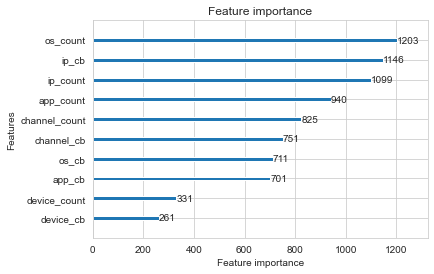

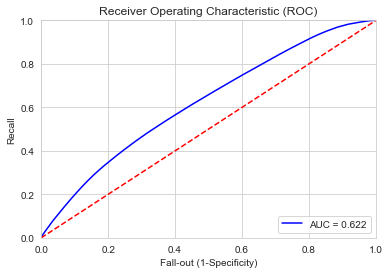

AUC score: 0.6224294010373158


<Figure size 432x288 with 0 Axes>

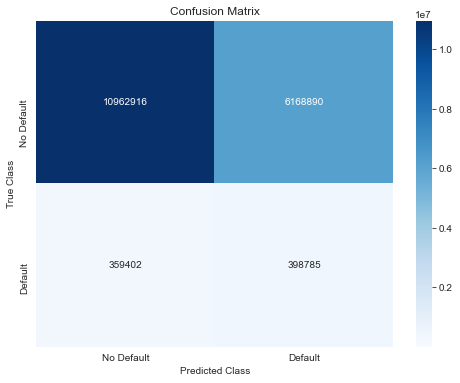

Test Eval
accuracy:  63.50869449753278
auc:  58.294389002331336
precision_score:  6.071935654550507
recall_score:  52.59718248928035


In [21]:
#Predict on test set
predictions_lgbm_prob = lgbm.predict(X_test)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

#--------------------------Print accuracy measures and variable importances----------------------
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(test['isFraud'],predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(test['isFraud'], predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test['isFraud'], predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


# evaluate predictions
#print("Test Eval")
#print("accuracy: ",accuracy_score(test['isFraud'],predictions_lgbm_01)*100)
#print("auc: ",roc_auc_score(test['isFraud'],predictions_lgbm_01)*100)
#print("precision_score: ",precision_score(test['isFraud'],predictions_lgbm_01)*100)
#print("recall_score: ",recall_score(test['isFraud'],predictions_lgbm_01)*100)

Overall accuracy of Light GBM model: 0.7863768308908785


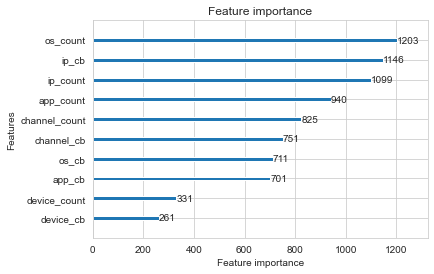

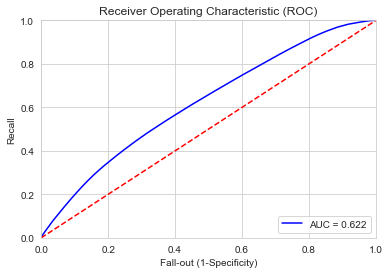

AUC score: 0.6224294010373158


<Figure size 432x288 with 0 Axes>

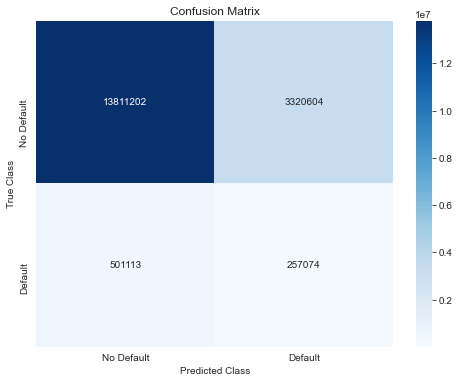

In [23]:
#Predict on test set
test['prediction']=lgbm.predict(test[feature_cols])
test['decile'] = pd.qcut(test['prediction'], 10, labels=False)

# At top 2 Decile
test['predict_fraud'] = np.where(test['decile']>=8, 1, 0)
predictions_lgbm_01 = test['predict_fraud']
#--------------------------Print accuracy measures and variable importances----------------------
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(test['isFraud'],predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(test['isFraud'], predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test['isFraud'], predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


# evaluate predictions
#print("Test Eval")
#print("accuracy: ",accuracy_score(test['isFraud'],predictions_lgbm_01)*100)
#print("auc: ",roc_auc_score(test['isFraud'],predictions_lgbm_01)*100)
#print("precision_score: ",precision_score(test['isFraud'],predictions_lgbm_01)*100)
#print("recall_score: ",recall_score(test['isFraud'],predictions_lgbm_01)*100)

## Profiling

<AxesSubplot:xlabel='predict_fraud', ylabel='count'>

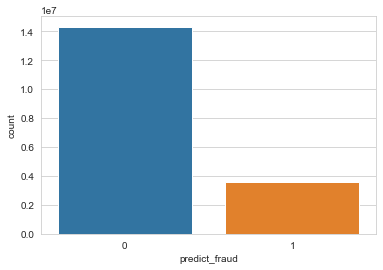

In [24]:
import seaborn as sns
sns.countplot(x='predict_fraud', data=test)

Plot feature importances...


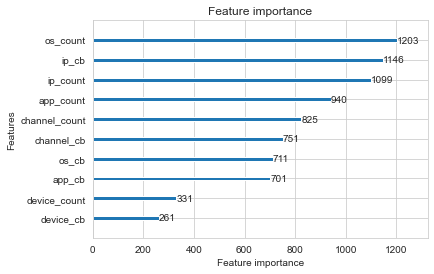

In [26]:
print('Plot feature importances...')
ax = lgb.plot_importance(lgbm, max_num_features=10)
plt.show()

In [27]:
feature_cols = ['ip_count', 'app_count', 'device_count','os_count', 'channel_count',
               'ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb']

In [28]:
profile_df = test.groupby('predict_fraud').agg({'ip_cb': ['mean'],
                                               'app_cb': ['mean'],
                                               'os_cb': ['mean'],
                                               'device_cb': ['mean'],
                                               'channel_cb': ['mean'],
                                               'ip_count': ['mean'],
                                               'app_count': ['mean'],
                                               'os_count': ['mean'],
                                               'device_count': ['mean'],
                                               'channel_count': ['mean']
                                               })

# rename columns
profile_df.columns = ['ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb','ip_count', 'app_count', 'device_count','os_count', 'channel_count']

# reset index to get grouped columns back
profile_df = profile_df.reset_index()



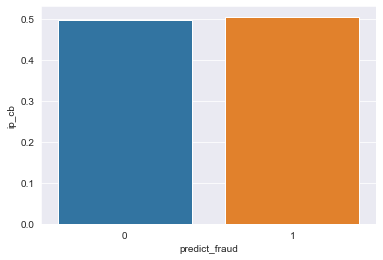

In [29]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "ip_cb", data = profile_df)
plt.show()

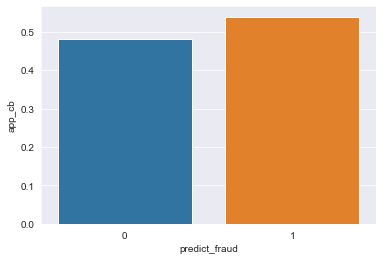

In [30]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "app_cb", data = profile_df)
plt.show()

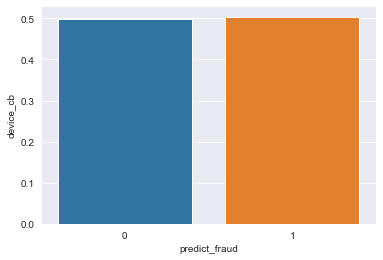

In [31]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "device_cb", data = profile_df)
plt.show()

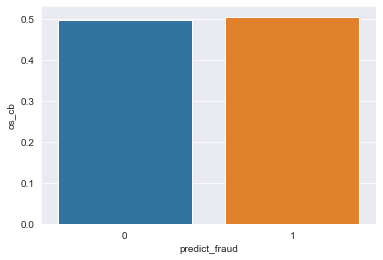

In [32]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "os_cb", data = profile_df)
plt.show()

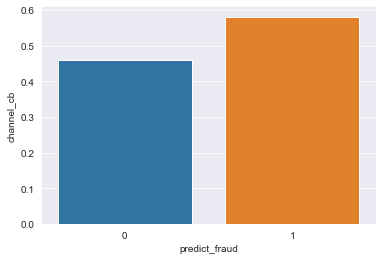

In [38]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "channel_cb", data = profile_df)
plt.show()

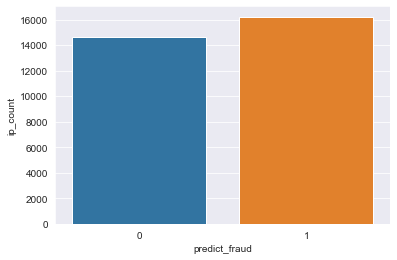

In [34]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "ip_count", data = profile_df)
plt.show()

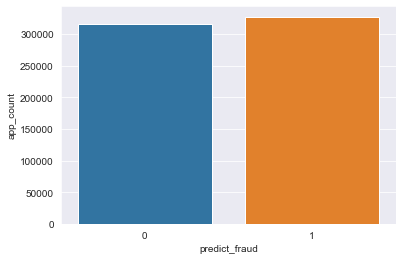

In [35]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "app_count", data = profile_df)
plt.show()

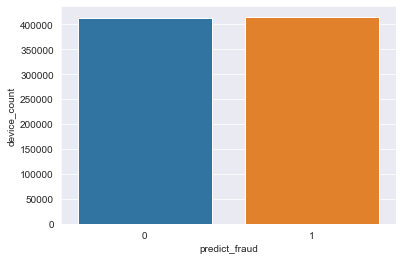

In [36]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "device_count", data = profile_df)
plt.show()

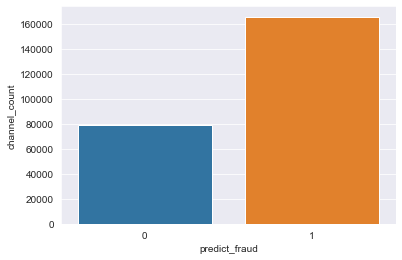

In [37]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "channel_count", data = profile_df)
plt.show()

## Model Explainer - SHAP

In [40]:
import joblib
lgbm_model = joblib.load('lgbm_final_model.pkl')

feature_cols = ['ip_count', 'app_count', 'device_count','os_count', 'channel_count',
               'ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb']

X_train = X_train[feature_cols]
X_test = test[feature_cols]

In [41]:
X_train

,ip_count,app_count,device_count,os_count,channel_count,ip_cb,app_cb,device_cb,os_cb,channel_cb
0,12276,55560,3316701,53689,12473,0.484035,0.479878,0.498937,0.488201,0.483045
1,15471,512619,3316701,840458,165114,0.520844,0.404328,0.498937,0.495007,0.235851
2,11648,512619,3316701,840458,49928,0.434415,0.404328,0.498937,0.495007,0.497316
3,15030,512619,3316701,77418,27664,0.519360,0.404328,0.498937,0.505412,0.489120
4,15118,512619,3316701,188410,165114,0.493849,0.404328,0.498937,0.510307,0.235851
...,...,...,...,...,...,...,...,...,...,...
3538853,10866,517660,3316701,54805,307245,0.499540,0.529711,0.498937,0.494061,0.653803
3538854,17571,517660,3316701,100006,161586,0.534344,0.529711,0.498937,0.494880,0.559702
3538855,13365,398151,3316701,37683,161586,0.500112,0.565574,0.498937,0.492716,0.559702
3538856,13336,44739,3316701,102167,35772,0.509672,0.613601,0.498937,0.503000,0.588111


In [ ]:
import shap

%time shap_values = shap.TreeExplainer(lgbm_model).shap_values(X_test)


In [ ]:
shap.summary_plot(shap_values, X_test)


In [47]:
shap.dependence_plot("channel_cb", shap_values, X_test)


TypeError: The passed shap_values are a list not an array! If you have a list of explanations try passing shap_values[0] instead to explain the first output class of a multi-output model.